## Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("stroke.csv")

In [3]:
print(data.shape)
data.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Preprocessing

### Unbalanced Columns

Checking the value distribution in categorical columns

In [4]:
cat_cols = ['gender', 'hypertension', 'heart_disease', 
            'ever_married','work_type', 'Residence_type',
            'smoking_status', 'stroke']

for col in cat_cols:
    print(col)
    print(data[col].value_counts())
    print('')

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

hypertension
0    4612
1     498
Name: hypertension, dtype: int64

heart_disease
0    4834
1     276
Name: heart_disease, dtype: int64

ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

stroke
0    4861
1     249
Name: stroke, dtype: int64



Removing the "Other" from gender

In [5]:
data[data.gender == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [6]:
data.drop(3116, axis=0, inplace=True)

### Missing Values

Checking for missing values in each column

In [7]:
for col in data.columns:
    print(col,data[col].isna().sum())

id 0
gender 0
age 0
hypertension 0
heart_disease 0
ever_married 0
work_type 0
Residence_type 0
avg_glucose_level 0
bmi 201
smoking_status 0
stroke 0


BMI imputation

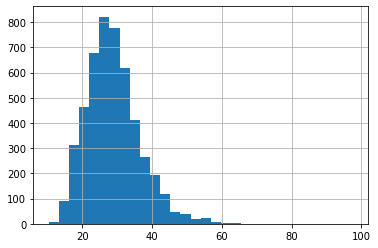

In [8]:
data.bmi.hist(bins=30);

Impute BMI larger than 60 as missing values

In [9]:
data.bmi = data.bmi.apply(lambda x: np.nan if x >= 60 else x)

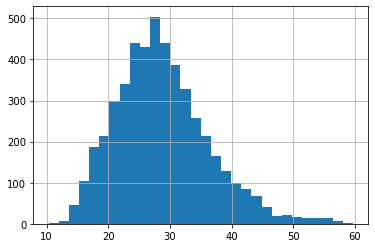

In [10]:
data.bmi.hist(bins=30);

Imputing missing values by average BMI

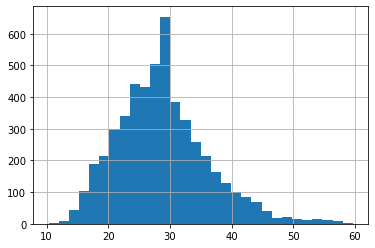

In [11]:
data.fillna(data.bmi.mean(), inplace=True)
data.bmi.hist(bins=30);

Imputing the "Unknown" category to "Occasional smoking"

In [12]:
data.replace("Unknown", "Occasional smoking", inplace=True)

In [13]:
data.smoking_status.value_counts()

never smoked          1892
Occasional smoking    1544
formerly smoked        884
smokes                 789
Name: smoking_status, dtype: int64

## Data Analysis

### Histogram of Numerical Variables

- The distribution of age resembles the uniform distribution with a small peak between 50 & 60.
<br><br>
- The distribution of BMI is almost normally distributed. The large number of patients around 30 is likely due to mean imputation.
<br><br>
- The distribution of average glucose level is bimodal.

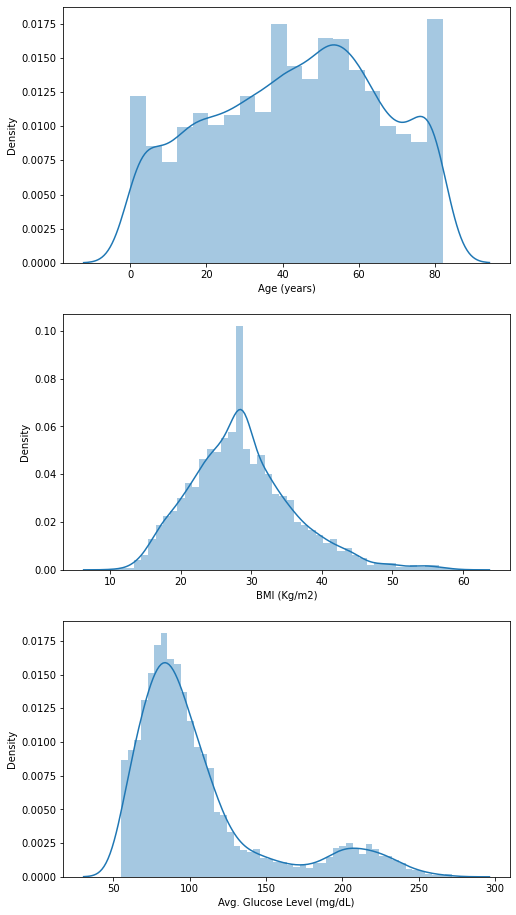

In [14]:
plt.figure(figsize=[8, 16])

plt.subplot(3, 1, 1)
sns.distplot(data.age);
plt.xlabel('Age (years)');

ax = plt.subplot(3, 1, 2)
sns.distplot(data.bmi);
plt.xlabel('BMI (Kg/m2)');

ax = plt.subplot(3, 1, 3)
sns.distplot(data.avg_glucose_level);
plt.xlabel('Avg. Glucose Level (mg/dL)');

### Patient Demographics

- The number of the 2 genders is similar with a slightly more females than males.
<br><br>
- Most of the participants are married and work privately.
<br><br>
- Almost half of the subjects reside in urban areas.

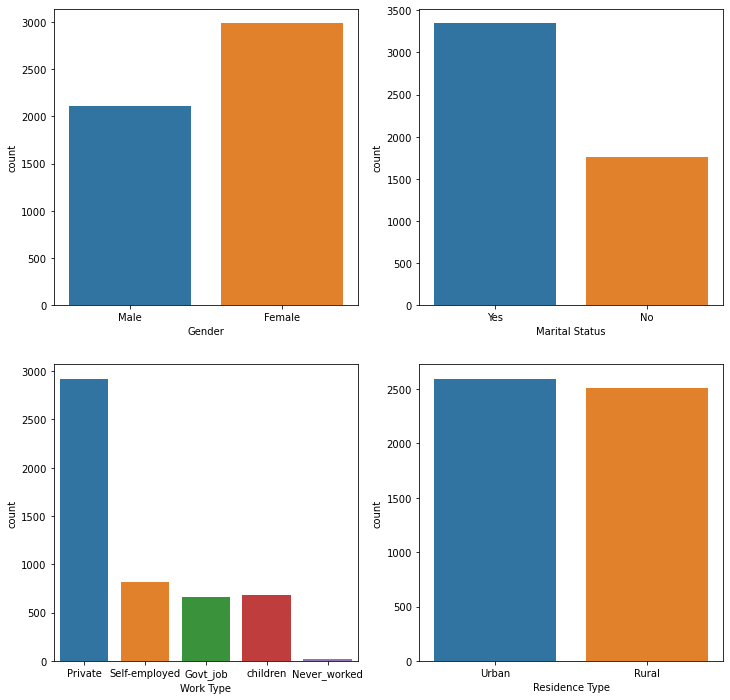

In [15]:
plt.figure(figsize=[12, 12])

plt.subplot(2, 2, 1)
sns.countplot(data.gender);
plt.xlabel('Gender');

ax = plt.subplot(2, 2, 2)
sns.countplot(data.ever_married);
plt.xlabel('Marital Status');

ax = plt.subplot(2, 2, 3)
sns.countplot(data.work_type);
plt.xlabel('Work Type');

ax = plt.subplot(2, 2, 4)
sns.countplot(data.Residence_type);
plt.xlabel('Residence Type');

### Diseases

- Most of the subjects do not have hypertension, heart disease or stroke.

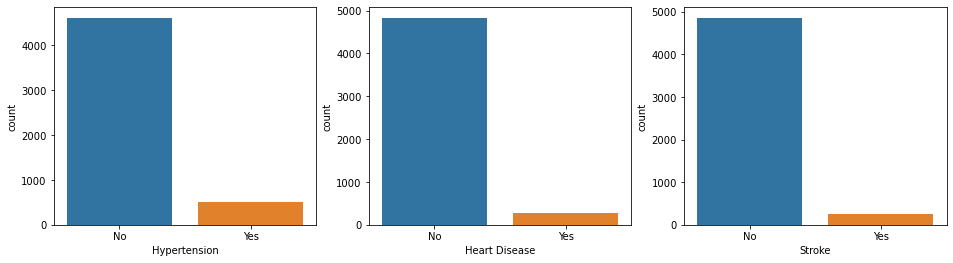

In [16]:
plt.figure(figsize=[16, 4])

plt.subplot(1, 3, 1)
sns.countplot(data.hypertension);
plt.xlabel('Hypertension');
plt.xticks([0,1] , ["No","Yes"]);

ax = plt.subplot(1, 3, 2)
sns.countplot(data.heart_disease);
plt.xlabel('Heart Disease');
plt.xticks([0,1] , ["No","Yes"]);

ax = plt.subplot(1, 3, 3)
sns.countplot(data.stroke);
plt.xlabel('Stroke');
plt.xticks([0,1] , ["No","Yes"]);

### Comparison between stroke patients and healthy subjects

In [17]:
df1 = pd.concat((data[data.stroke == 0].sample(250), data[data.stroke == 1]))


- The age of stroke patients is often centered around (60-80), while healthy patients can be of any age. Therefore, old age may increase the risk of stroke.
<br>
<br>
- BMI is similar for both stroke patients and healthy subjects. However, the curve of healthy subjects is more spread.
<br>
<br>
- The average glucose level of stroke patients is more shifted to the left compared to the healthy subjects, which might suggests that it can increase the risk of stroke.

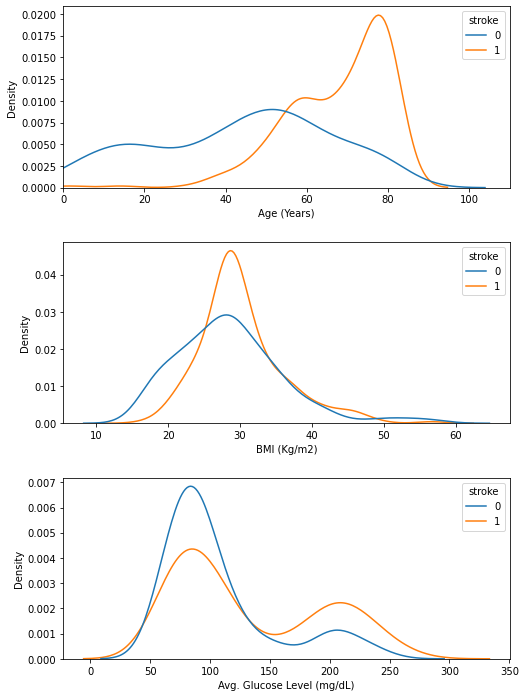

In [18]:
plt.figure(figsize=[8, 12])
plt.subplots_adjust(hspace=0.3)

plt.subplot(3, 1, 1)
sns.kdeplot(data = df1, x = 'age', hue = 'stroke');
plt.xlabel('Age (Years)');
plt.xlim(0,110);

ax = plt.subplot(3, 1, 2)
sns.kdeplot(data = df1, x = 'bmi', hue = 'stroke');
plt.xlabel('BMI (Kg/m2)');

ax = plt.subplot(3, 1, 3)
sns.kdeplot(data = df1, x = 'avg_glucose_level', hue = 'stroke');
plt.xlabel('Avg. Glucose Level (mg/dL)');

- People who have hypertension and heart disease seem to be more likely to have stroke.

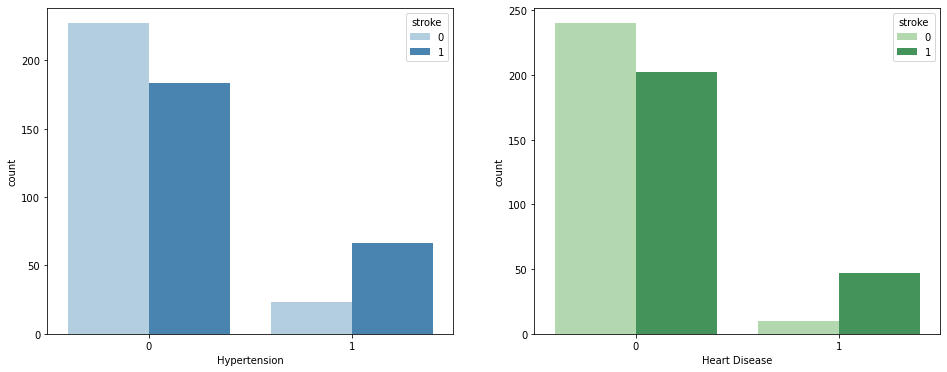

In [19]:
plt.figure(figsize=[16,6])
plt.subplots_adjust(hspace=0.3)

plt.subplot(1, 2, 1)
sns.countplot(data = df1, x = 'hypertension', hue = 'stroke', palette = 'Blues');
plt.xlabel('Hypertension');
plt.xticks([0,1] , ["0","1"]);

ax = plt.subplot(1, 2, 2)
sns.countplot(data = df1, x = 'heart_disease', hue = 'stroke', palette = 'Greens');
plt.xlabel('Heart Disease');
plt.xticks([0,1] , ["0","1"]);

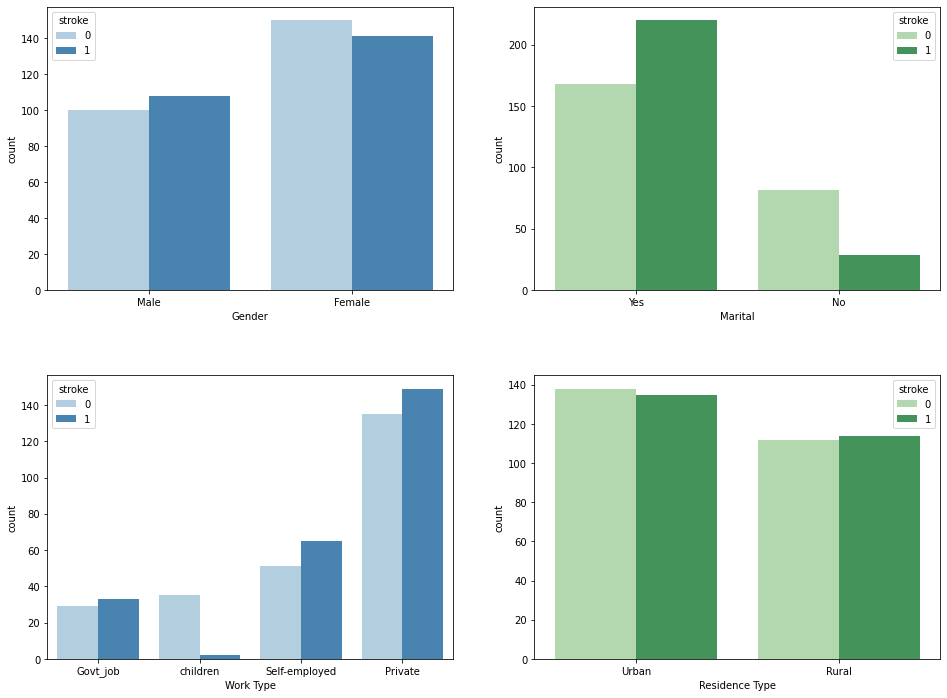

In [20]:
plt.figure(figsize=[16,12])
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
sns.countplot(data = df1, x = 'gender', hue = 'stroke', palette = 'Blues');
plt.xlabel('Gender');

ax = plt.subplot(2, 2, 2)
sns.countplot(data = df1, x = 'ever_married', hue = 'stroke', palette = 'Greens');
plt.xlabel('Marital');

plt.subplot(2, 2, 3)
sns.countplot(data = df1, x = 'work_type', hue = 'stroke', palette = 'Blues');
plt.xlabel('Work Type');

ax = plt.subplot(2, 2, 4)
sns.countplot(data = df1, x = 'Residence_type', hue = 'stroke', palette = 'Greens');
plt.xlabel('Residence Type');

## Stroke Prediction (ML)

### Preprocessing

Drop the unnecessary columns (ID, Work Type, Residence Type)

In [21]:
df2 = data.drop(columns = ["id", "work_type", "Residence_type"])

Change categorical variables (Gender, Marital Status) the have only 2 values to binary

In [22]:
df2.gender[df2.gender == "Female"] = 1 
df2.gender[df2.gender == "Male"] = 0
df2.gender = df2.gender.astype(int)

df2.ever_married[df2.ever_married == "Yes"] = 1 
df2.ever_married[df2.ever_married == "No"] = 0
df2.ever_married = df2.ever_married.astype(int)

Transform categorical variables (Smoking Status) with multiple values into one-hot-encoded columns

In [23]:
df2 = pd.get_dummies(df2)

Scale the numerical variables into the same range (0 - 1) using min-max scaling technique:

<font color='blue'> $$\frac{x - min(x)}{max(x) - min(x)}$$ <font>

In [24]:
scaler = MinMaxScaler()
scaler.fit(df2[["age","avg_glucose_level","bmi"]])
df2[["age","avg_glucose_level","bmi"]] = scaler.transform(df2[["age","avg_glucose_level","bmi"]])

df2.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,smoking_status_Occasional smoking,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,0.816895,0,1,1,0.801265,0.532389,1,0,1,0,0
1,1,0.743652,0,0,1,0.679023,0.374225,1,0,0,1,0
2,0,0.975586,0,1,1,0.234512,0.449393,1,0,0,1,0
3,1,0.597168,0,0,1,0.536008,0.487854,1,0,0,0,1
4,1,0.963379,1,0,1,0.549349,0.277328,1,0,0,1,0


Partition the data into trainig set and test set with sizes 70% and 30% respectively

In [25]:
train, test = train_test_split(df2, test_size=0.3, random_state=40)

train_labels = train.stroke
test_labels = test.stroke

Oversampling the data to avoid imbalance in the target column

In [26]:
print("Percent of Stroke Patients before Oversampling:", train_labels.sum() * 100 / train_labels.shape[0])

sm = SMOTE(sampling_strategy='minority', random_state=40)

train, train_labels = sm.fit_sample(train.drop('stroke', axis=1), train['stroke'])
test, test_labels = sm.fit_sample(test.drop('stroke', axis=1), test['stroke'])

print("Percent of Stroke Patients after Oversampling:", train_labels.sum() * 100 / train_labels.shape[0])

Percent of Stroke Patients before Oversampling: 4.977628635346756
Percent of Stroke Patients after Oversampling: 50.0


### Training & Prediction

#### Logistic Regression

In [27]:
# Instantiate Logistic Regression
log_reg = LogisticRegression()

# Train on the training data and the trainig labels
log_reg.fit(train, train_labels)

# Predict the labels of the test data
log_reg_pred = log_reg.predict(test)
log_reg_pred_prob = log_reg.predict_proba(test)[:,1]

# Calculate scores for model evaluation
print(classification_report(test_labels, log_reg_pred))
print('Accuracy:', accuracy_score(test_labels, log_reg_pred))
print("F1 Score:", f1_score(test_labels, log_reg_pred))
print('AUC:', roc_auc_score(test_labels, log_reg_pred_prob))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1462
           1       0.74      0.75      0.75      1462

    accuracy                           0.74      2924
   macro avg       0.74      0.74      0.74      2924
weighted avg       0.74      0.74      0.74      2924

Accuracy: 0.7445280437756497
F1 Score: 0.746177370030581
AUC: 0.8129410641869448


#### SVM

In [30]:
# Instantiate Support Vector Machines
clf = svm.SVC(kernel='linear',probability=True)

# Train on the training data and the trainig labels
clf.fit(train, train_labels)

# Predict the labels of the test data
svm_pred = clf.predict(test)
svm_pred_prob = clf.predict_proba(test)[:,1]

# Calculate scores for model evaluation
print(classification_report(test_labels, svm_pred))
print('Accuracy:', accuracy_score(test_labels, svm_pred))
print("F1 Score:", f1_score(test_labels, svm_pred))
print('AUC:', roc_auc_score(test_labels, svm_pred_prob))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1462
           1       0.74      0.79      0.76      1462

    accuracy                           0.76      2924
   macro avg       0.76      0.76      0.76      2924
weighted avg       0.76      0.76      0.76      2924

Accuracy: 0.7571819425444597
F1 Score: 0.7639627659574468
AUC: 0.8159282769513494


#### Random Forest

In [31]:
# Instantiate Random Forest
random_forest = RandomForestClassifier()

# Train on the training data and the trainig labels
random_forest.fit(train, train_labels)

# Predict the labels of the test data
forest_pred = random_forest.predict(test)
forest_pred_prob = random_forest.predict_proba(test)[:,1]

# Calculate scores for model evaluation
print(classification_report(test_labels, forest_pred))
print('Accuracy:', accuracy_score(test_labels, forest_pred))
print("F1 Score:", f1_score(test_labels, forest_pred))
print('AUC:', roc_auc_score(test_labels, forest_pred_prob))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76      1462
           1       0.84      0.53      0.65      1462

    accuracy                           0.71      2924
   macro avg       0.75      0.71      0.70      2924
weighted avg       0.75      0.71      0.70      2924

Accuracy: 0.7144322845417237
F1 Score: 0.648421052631579
AUC: 0.8575188402596746


**Random Forest is the best classifier in terms of ROC-AUC. However, SVM seems to be the highest performing in terms of accuracy and F1 score.**